# 数据导入

In [127]:
import pandas as pd

import matplotlib

import seaborn as sns

import numpy as np

import scipy as sp

import sklearn

import random 

import time

import os

import warnings
warnings.filterwarnings('ignore')
print('-'*25)

-------------------------


In [128]:
# Models
from sklearn import svm,tree,linear_model,neighbors,naive_bayes,ensemble,discriminant_analysis,gaussian_process
from xgboost import XGBClassifier

#Common Model Helpers
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics

#visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
from pandas.tools.plotting import scatter_matrix

mpl.style.use('ggplot')
sns.set_style('white')
pylab.rcParams['figure.figsize'] = 12,8

In [129]:
print(os.listdir('F:\\DF\\CMB\\input'))

['test_agg.csv', 'test_log.csv', 'train_agg.csv', 'train_flg.csv', 'train_log.csv']


In [130]:
train_agg=pd.read_csv('F:\\DF\\CMB\\input\\train_agg.csv',sep='\t')
train_flg=pd.read_csv('F:\\DF\\CMB\\input\\train_flg.csv',sep='\t')
train_log=pd.read_csv('F:\\DF\\CMB\\input\\train_log.csv',sep='\t')

test_agg=pd.read_csv('F:\\DF\\CMB\\input\\test_agg.csv',sep='\t')
test_log=pd.read_csv('F:\\DF\\CMB\\input\\test_log.csv',sep='\t')

In [131]:
print(train_agg.info())
print('--'*10)
print(train_log.info())
print('--'*10)
print(train_flg.info())
print('--'*10)
print(test_agg.info())
print('--'*10)
print(test_log.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 31 columns):
V1       80000 non-null float64
V2       80000 non-null float64
V3       80000 non-null float64
V4       80000 non-null float64
V5       80000 non-null float64
V6       80000 non-null float64
V7       80000 non-null float64
V8       80000 non-null float64
V9       80000 non-null float64
V10      80000 non-null float64
V11      80000 non-null float64
V12      80000 non-null float64
V13      80000 non-null float64
V14      80000 non-null float64
V15      80000 non-null float64
V16      80000 non-null float64
V17      80000 non-null float64
V18      80000 non-null float64
V19      80000 non-null float64
V20      80000 non-null float64
V21      80000 non-null float64
V22      80000 non-null float64
V23      80000 non-null float64
V24      80000 non-null float64
V25      80000 non-null float64
V26      80000 non-null float64
V27      80000 non-null float64
V28      80000 non-null flo

train_log数据中有两列为object类型，其余数据均为数值型

# EDA

检查flg，y值的分布

0    76824
1     3176
Name: FLAG, dtype: int64
----------


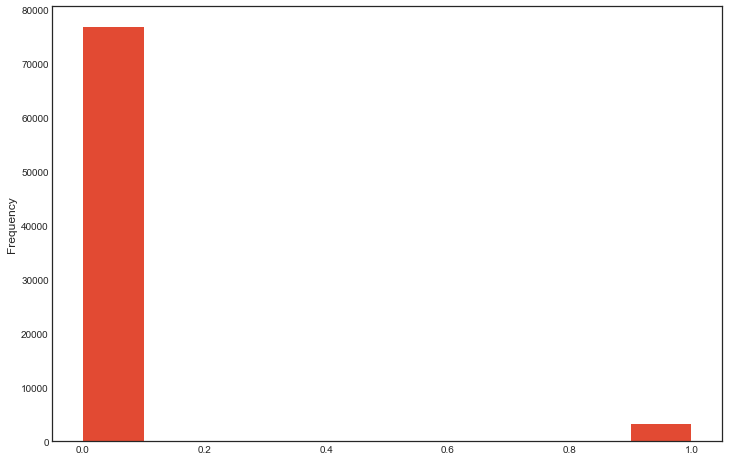

In [132]:
print(train_flg['FLAG'].value_counts())
print('-'*10)
train_flg['FLAG'].plot.hist()

可以看出此问题为不等分类问题，后续可能需要用到权重值来进行加权。

## Missing Values

In [133]:
def missing_values_table(df):
    mis_val=df.isnull().sum()
    mis_val_percent=100*df.isnull().sum()/len(df)
    mis_val_table=pd.concat([mis_val,mis_val_percent],axis=1)
    mis_val_table_ren_columns=mis_val_table.rename(columns={0:'Missing Values',1:'% of Total Values'})
    mis_val_table_ren_columns=mis_val_table_ren_columns[mis_val_table_ren_columns.iloc[:,1]!=0].sort_values('% of Total Values', ascending=False).round(2)
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
    return mis_val_table_ren_columns

In [134]:
missing_values=missing_values_table(train_agg)
print('-'*10)
missing_values=missing_values_table(train_log)
print('-'*10)
missing_values=missing_values_table(train_flg)
print('-'*10)
missing_values=missing_values_table(test_agg)
print('-'*10)
missing_values=missing_values_table(test_log)
print('-'*10)

Your selected dataframe has 31 columns.
There are 0 columns that have missing values.
----------
Your selected dataframe has 4 columns.
There are 0 columns that have missing values.
----------
Your selected dataframe has 2 columns.
There are 0 columns that have missing values.
----------
Your selected dataframe has 31 columns.
There are 0 columns that have missing values.
----------
Your selected dataframe has 4 columns.
There are 0 columns that have missing values.
----------


所有数据集中没有缺失值。

## 特征处理

首先查看_agg数据集各个特征的相关。

In [135]:
def correlation_heatmap(df):
    _,ax=plt.subplots(figsize=(14,12))
    colormap=sns.diverging_palette(255,15,as_cmap=True)
    
    _=sns.heatmap(
        df.corr(),cmap=colormap,square=True,cbar_kws={'shrink':.95},
        ax=ax,annot=True,linewidths=0.05,vmax=1,linecolor='white',
        annot_kws={'fontsize':8}
        )
    plt.title('Pearson Correlation of Features',y=1.05,size=5)

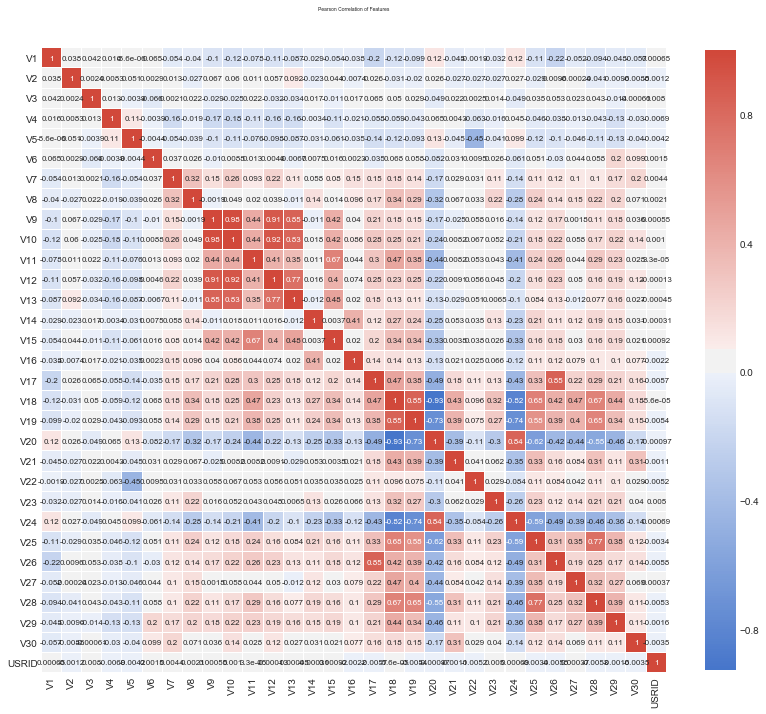

In [136]:
correlation_heatmap(train_agg)

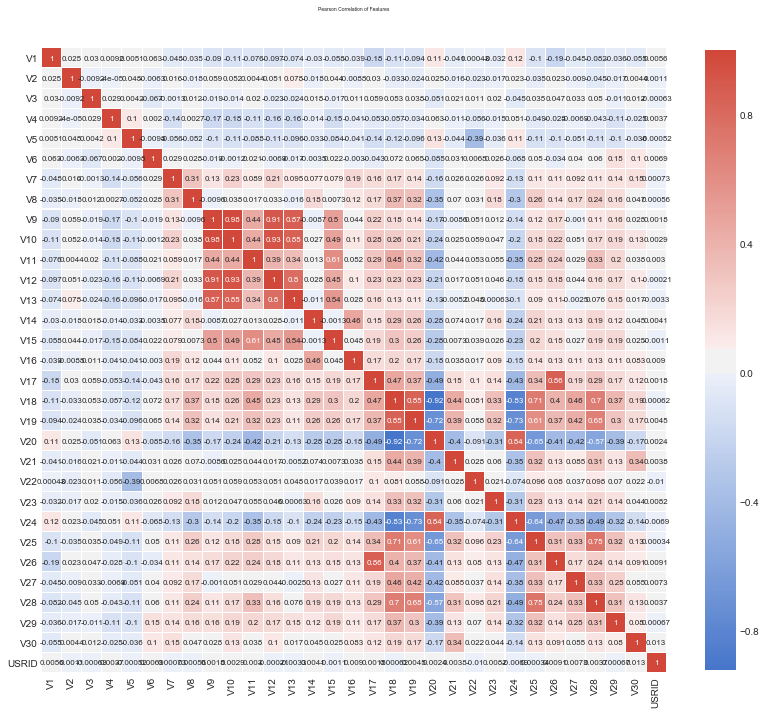

In [137]:
correlation_heatmap(test_agg)

从热图中可以看到一些特征之间存在强烈相关，后续模型建立时应考虑。

In [138]:
train_log.select_dtypes('object').apply(pd.Series.nunique,axis=0)

EVT_LBL        595
OCC_TIM    1618440
dtype: int64

In [139]:
train_log['OCC_TIM'].head(10)

0    2018-03-22 16:31:44
1    2018-03-22 16:31:18
2    2018-03-22 16:31:15
3    2018-03-06 12:08:51
4    2018-03-09 14:40:22
5    2018-03-16 17:45:42
6    2018-03-15 10:40:35
7    2018-03-06 12:07:02
8    2018-03-09 11:23:01
9    2018-03-22 16:31:13
Name: OCC_TIM, dtype: object

可以看到log数据集中两个object特征的分类数都比较多，其中OCC_TIM为时间序列。针对log数据，可以考虑统计各个用户进行app操作行为的频次（按年、月和日分开），也可以根据特定时间点操作次数进行分类。先统计出train_log和test_log分别有多少USRID，是否重叠。

In [140]:
print(train_log['USRID'].drop_duplicates(keep='first').count())
print('-'*10)
print(test_log['USRID'].drop_duplicates(keep='first').count())

39028
----------
9847


In [141]:
pd.concat([train_log['USRID'],test_log['USRID']]).drop_duplicates(keep='first').count()

48875

由上可以看出，log数据中USRID并没有重复，两个数据集可以合并进行特征处理。

In [142]:
train_log1=train_log.copy()
train_log1['tt']='train'
test_log1=test_log.copy()
test_log1['tt']='test'

In [143]:
log_data=pd.concat([train_log1,test_log1])
log_data.head()

,USRID,EVT_LBL,OCC_TIM,TCH_TYP,tt
0,10002,163-577-913,2018-03-22 16:31:44,0,train
1,10002,163-578-914,2018-03-22 16:31:18,0,train
2,10002,259-924-1525,2018-03-22 16:31:15,0,train
3,10002,326-1040-1677,2018-03-06 12:08:51,0,train
4,10002,326-1041-1678,2018-03-09 14:40:22,0,train


将时间序列分割出年，月，日与小时。

In [144]:
log_data['year']=list(map(lambda s:s.split('-')[0],log_data['OCC_TIM']))
log_data['month']=list(map(lambda s:s.split('-')[1],log_data['OCC_TIM']))
log_data['day']=list(map(lambda s:(s.split('-')[2]).split(' ')[0],log_data['OCC_TIM']))
log_data['hour']=list(map(lambda s:((s.split('-')[2]).split(' ')[1]).split(':')[0],log_data['OCC_TIM']))

In [145]:
log_data.head(10)

,USRID,EVT_LBL,OCC_TIM,TCH_TYP,tt,year,month,day,hour
0,10002,163-577-913,2018-03-22 16:31:44,0,train,2018,03,22,16
1,10002,163-578-914,2018-03-22 16:31:18,0,train,2018,03,22,16
2,10002,259-924-1525,2018-03-22 16:31:15,0,train,2018,03,22,16
3,10002,326-1040-1677,2018-03-06 12:08:51,0,train,2018,03,06,12
4,10002,326-1041-1678,2018-03-09 14:40:22,0,train,2018,03,09,14
5,10002,326-1041-1678,2018-03-16 17:45:42,0,train,2018,03,16,17
6,10002,359-1234-2004,2018-03-15 10:40:35,0,train,2018,03,15,10
7,10002,520-1836-3640,2018-03-06 12:07:02,0,train,2018,03,06,12
8,10002,520-1836-3640,2018-03-09 11:23:01,0,train,2018,03,09,11
9,10002,520-1836-3640,2018-03-22 16:31:13,0,train,2018,03,22,16


年月日，小时分别拼接为：年月，年月日，年月日小时，并进行统计。

In [146]:
log_data['year']=list(map(lambda s:str(s),log_data['year']))
log_data['month']=list(map(lambda s:str(s),log_data['month']))
log_data['day']=list(map(lambda s:str(s),log_data['day']))
log_data['hour']=list(map(lambda s:str(s),log_data['hour']))

In [147]:
log_data['YM']=log_data['year']+log_data['month']
log_data['YMD']=log_data['year']+log_data['month']+log_data['day']
log_data['YMDH']=log_data['year']+log_data['month']+log_data['day']+log_data['hour']

In [148]:
log_data.head()

,USRID,EVT_LBL,OCC_TIM,TCH_TYP,tt,year,month,day,hour,YM,YMD,YMDH
0,10002,163-577-913,2018-03-22 16:31:44,0,train,2018,03,22,16,201803,20180322,2018032216
1,10002,163-578-914,2018-03-22 16:31:18,0,train,2018,03,22,16,201803,20180322,2018032216
2,10002,259-924-1525,2018-03-22 16:31:15,0,train,2018,03,22,16,201803,20180322,2018032216
3,10002,326-1040-1677,2018-03-06 12:08:51,0,train,2018,03,06,12,201803,20180306,2018030612
4,10002,326-1041-1678,2018-03-09 14:40:22,0,train,2018,03,09,14,201803,20180309,2018030914


In [149]:
log_data.select_dtypes('object').apply(pd.Series.nunique,axis=0)

EVT_LBL        616
OCC_TIM    1783467
tt               2
year             1
month            1
day             31
hour            24
YM               1
YMD             31
YMDH           744
dtype: int64

由上可以看出数据集中的数据都为2018年，时间分布在3月内。因此我们可以将year，month剔除，只保留YMD和YMDH

In [150]:
log_data_c=log_data[['USRID','EVT_LBL','OCC_TIM','TCH_TYP','YMD','YMDH','tt']]

In [151]:
log_data_c.head()

,USRID,EVT_LBL,OCC_TIM,TCH_TYP,YMD,YMDH,tt
0,10002,163-577-913,2018-03-22 16:31:44,0,20180322,2018032216,train
1,10002,163-578-914,2018-03-22 16:31:18,0,20180322,2018032216,train
2,10002,259-924-1525,2018-03-22 16:31:15,0,20180322,2018032216,train
3,10002,326-1040-1677,2018-03-06 12:08:51,0,20180306,2018030612,train
4,10002,326-1041-1678,2018-03-09 14:40:22,0,20180309,2018030914,train


0    4418731
2       6501
Name: TCH_TYP, dtype: int64
----------


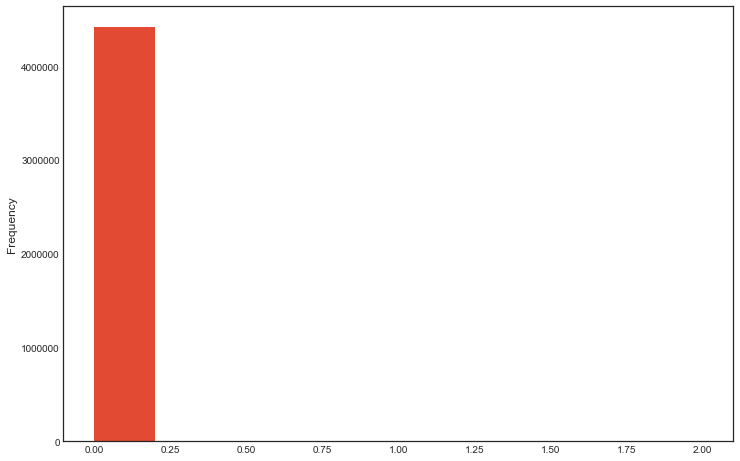

In [152]:
print(log_data_c['TCH_TYP'].value_counts())
print('-'*10)
log_data_c['TCH_TYP'].plot.hist()

绝大多数用户使用APP进行操作，极少数使用H5，无人使用Web。

In [153]:
log_data_c['YMD']=list(map(lambda s:int(s),log_data_c['YMD']))
log_data_c['YMDH']=list(map(lambda s:int(s),log_data_c['YMDH']))

20180307    179093
20180321    172556
20180326    170184
20180323    164013
20180328    159658
20180306    157158
20180308    152621
20180314    151975
20180301    151884
20180309    151303
20180305    151229
20180320    150546
20180302    149113
20180325    145290
20180319    142866
20180324    142779
20180303    140624
20180304    139219
20180315    137956
20180310    136930
20180313    136371
20180312    135536
20180329    134075
20180330    130196
20180316    129826
20180327    126139
20180317    125711
20180331    124705
20180318    119583
20180311    117715
20180322     98378
Name: YMD, dtype: int64
----------


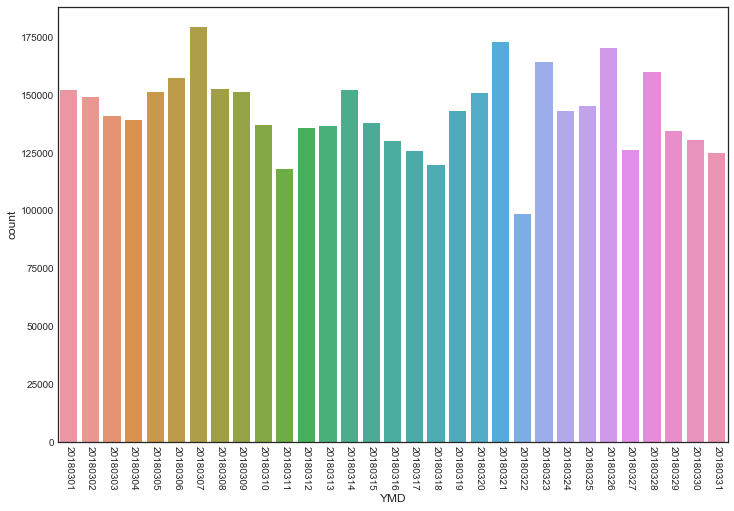

In [154]:
print(log_data_c['YMD'].value_counts())
print('-'*10)
ax=sns.countplot(x='YMD',data=log_data_c)
ax=ax.set_xticklabels(ax.get_xticklabels(), rotation=-90)

可以看出总体数据分布时比较均匀的，下面分成train,test数据来作图。

In [155]:
train_log_t=log_data_c[log_data['tt']=='train']
test_log_t=log_data_c[log_data['tt']=='test']

Train data
 20180307    142750
20180321    137063
20180326    135864
20180323    131978
20180328    125903
20180306    125439
20180314    122558
20180308    121964
20180301    121912
20180305    121559
20180309    120939
20180320    119532
20180302    119217
20180325    115420
20180324    114091
20180319    113782
20180303    112086
20180304    111300
20180315    110782
20180310    109259
20180313    109079
20180312    108917
20180329    106491
20180330    104231
20180316    103988
20180327    100496
20180317    100488
20180331     99741
20180318     95466
20180311     93844
20180322     77679
Name: YMD, dtype: int64
----------
Train data
 20180307    36343
20180321    35493
20180326    34320
20180328    33755
20180323    32035
20180306    31719
20180320    31014
20180308    30657
20180309    30364
20180301    29972
20180302    29896
20180325    29870
20180305    29670
20180314    29417
20180319    29084
20180324    28688
20180303    28538
20180304    27919
20180310    27671
20180329  

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]),
 <a list of 31 Text xticklabel objects>)

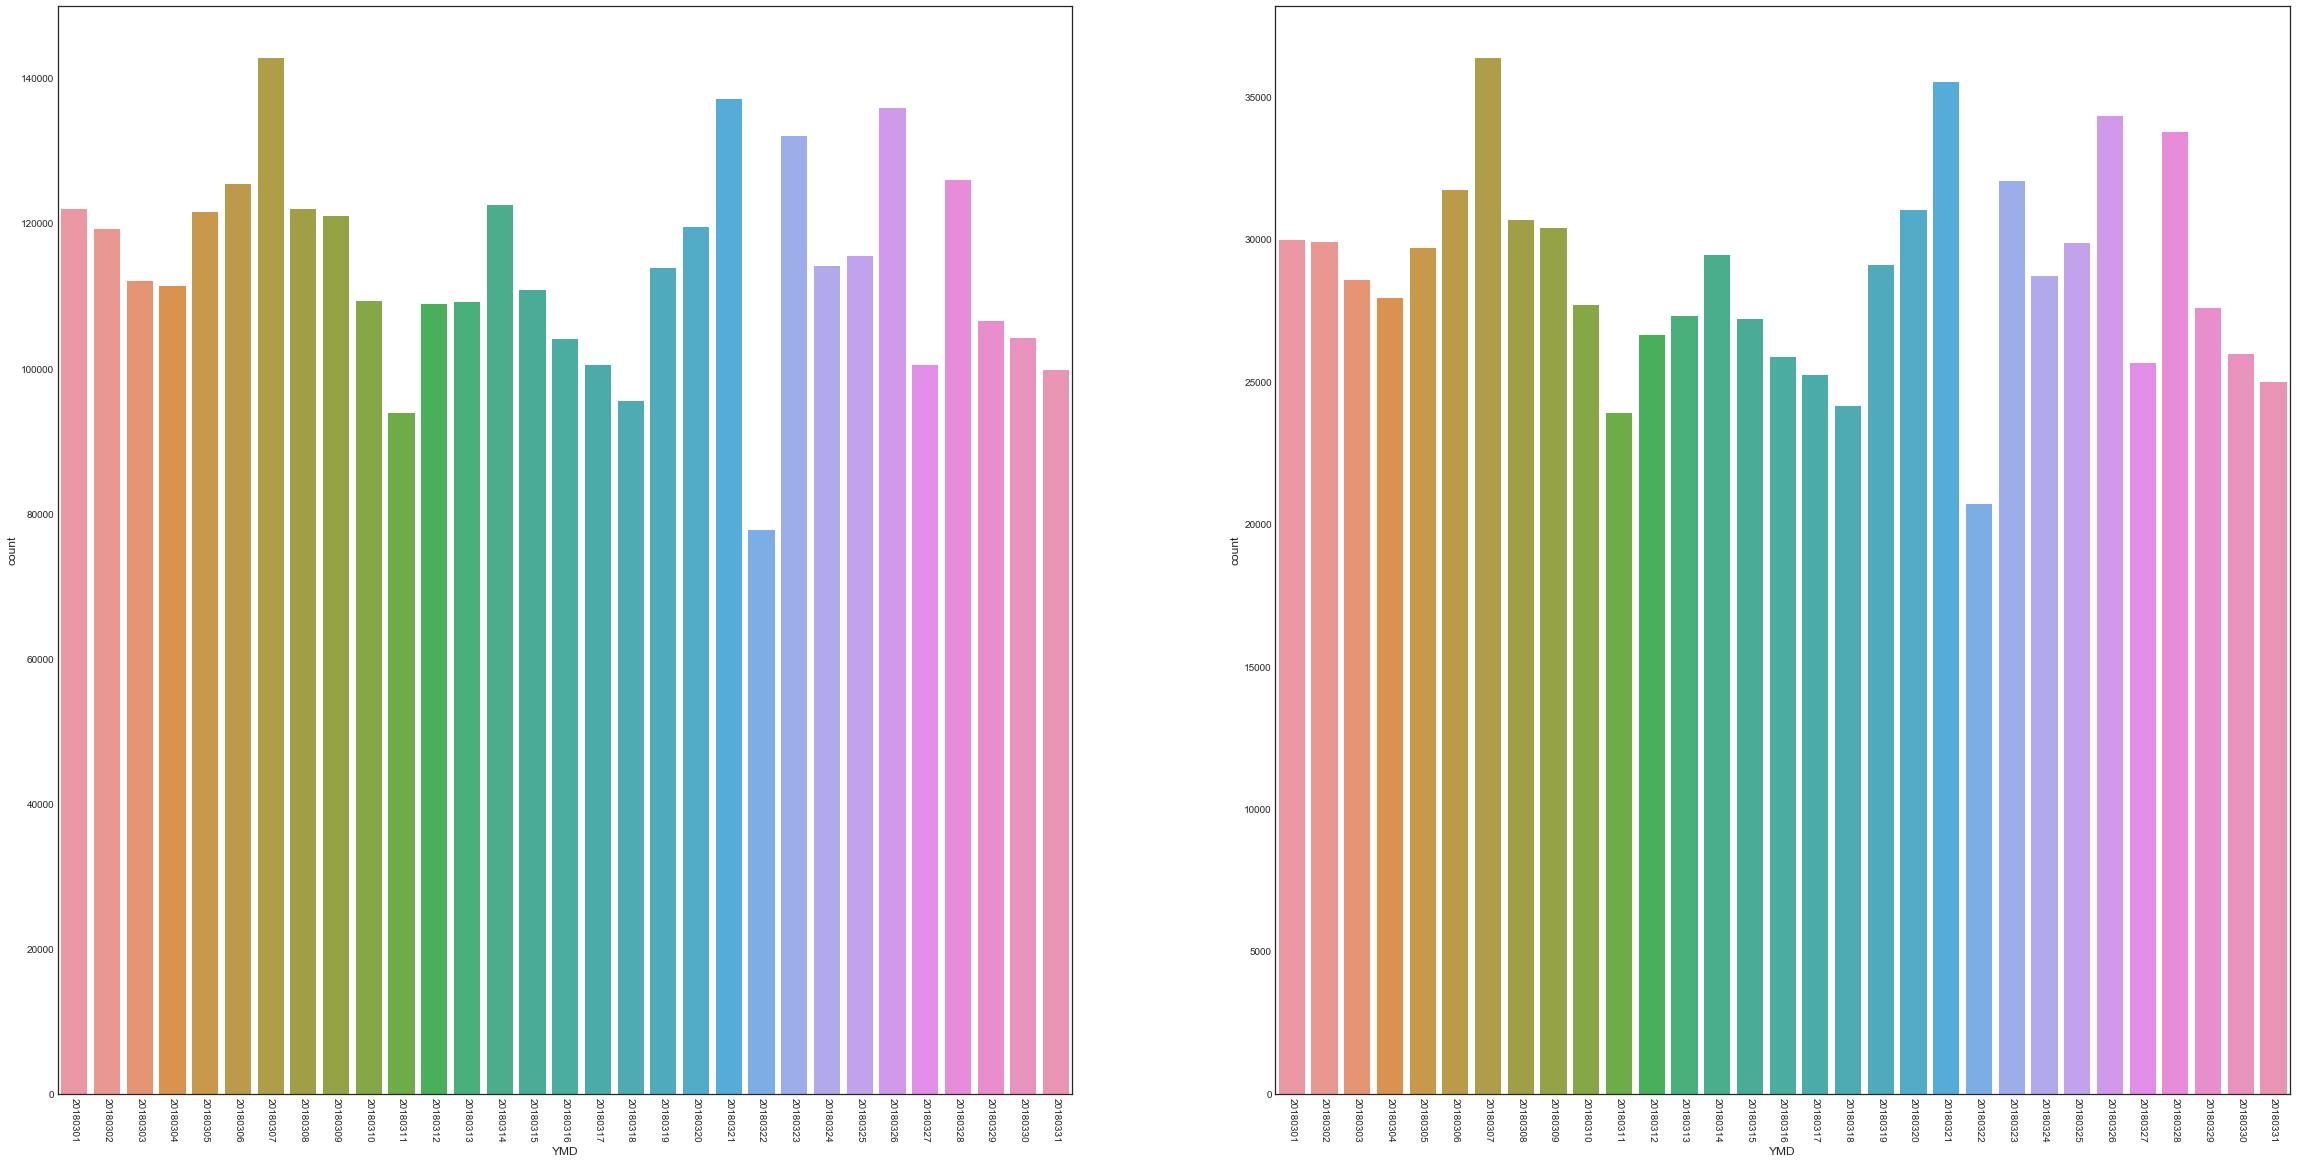

In [156]:
print('Train data\n',train_log_t['YMD'].value_counts())
print('-'*10)
print('Train data\n',test_log_t['YMD'].value_counts())
print('-'*10)

fig = plt.figure(figsize=(40,20))  
fig.add_subplot(121) 
sns.countplot(x='YMD',data=train_log_t)
plt.xticks(rotation=-90)


fig.add_subplot(122) 
sns.countplot(x='YMD',data=test_log_t)
plt.xticks(rotation=-90)

可以看出两组数据的分布基本一致。接下来根据用户使用APP的次数作为特征进行提取，可初步定为用户月总使用次数以及连续使用天数（例如连续几天使用3次以上）

下面对EVT_LBL特征进行处理。由上可知该特征有616个分类。

In [157]:
log_data_c['EVT1']=list(map(lambda s:s.split('-')[0],log_data['EVT_LBL']))
log_data_c['EVT2']=list(map(lambda s:s.split('-')[1],log_data['EVT_LBL']))
log_data_c['EVT3']=list(map(lambda s:s.split('-')[2],log_data['EVT_LBL']))

In [158]:
log_data_c.select_dtypes('object').apply(pd.Series.nunique,axis=0)

EVT_LBL        616
OCC_TIM    1783467
tt               2
EVT1            21
EVT2           178
EVT3           616
dtype: int64

可以看到点击模块的三个级别中导致分类数量增加的级别为第三级，作图观察三种级别的数据分布。

In [159]:
log_data_c['EVT1']=list(map(lambda s:int(s),log_data_c['EVT1']))
log_data_c['EVT2']=list(map(lambda s:int(s),log_data_c['EVT2']))
log_data_c['EVT3']=list(map(lambda s:int(s),log_data_c['EVT3']))

EVT1 data
 326    1550293
520     839540
0       360214
359     335802
38      299745
257     233936
259     162188
518     131134
604     124235
163      97427
139      91939
102      54243
372      35127
396      26104
438      21379
162      16415
460      14785
540      13653
10        9168
181       4098
508       3807
Name: EVT1, dtype: int64
----------
EVT2 data
 1041    976359
1836    733001
231     359381
1234    322319
115     299745
922     233936
1040    176398
1042    169471
924     162188
1047    160118
392      70797
2148     55737
314      54243
1828     53434
1841     49014
1831     37243
578      35874
576      31772
577      29781
1830     27475
1046     25905
2140     25785
1043     23884
395      21081
1861     16199
1349     15494
1484     14555
2142     13078
1827     10176
1048     10108
         ...  
1269        36
2147        35
393         34
557         27
394         27
230         24
229         20
1849        20
232         19
2150        18
2135        

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
        169, 170, 171, 172, 173, 174, 175, 176, 177

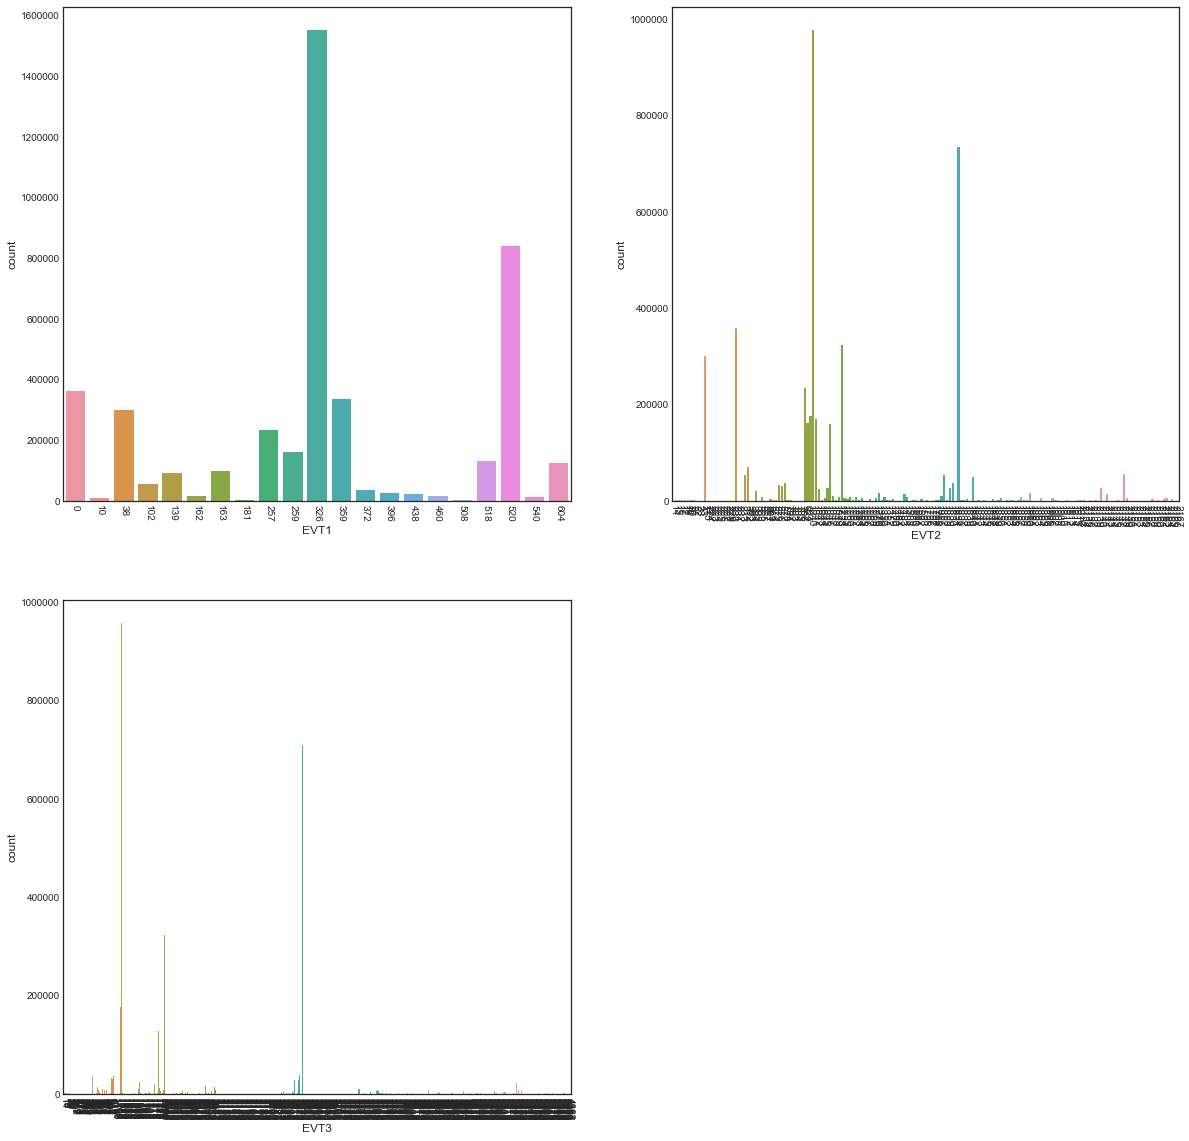

In [160]:
print('EVT1 data\n',log_data_c['EVT1'].value_counts())
print('-'*10)
print('EVT2 data\n',log_data_c['EVT2'].value_counts())
print('-'*10)
print('EVT3 data\n',log_data_c['EVT3'].value_counts())
print('-'*10)

fig = plt.figure(figsize=(20,20))  
fig.add_subplot(221) 
sns.countplot(x='EVT1',data=log_data_c)
plt.xticks(rotation=-90)


fig.add_subplot(222) 
sns.countplot(x='EVT2',data=log_data_c)
plt.xticks(rotation=-90)


fig.add_subplot(223) 
sns.countplot(x='EVT3',data=log_data_c)
plt.xticks(rotation=-90)

EVT2和EVT3中可明显看到数据分布不均匀，一些数据出现的频率非常高，这里先选择两个特征类别数量前21（与EVT1保持一致）的数据再次进行作图观察。

In [161]:
EVT2=log_data_c.groupby(log_data_c['EVT2'],as_index=False).count().sort_values('USRID',ascending=False).iloc[:21,:]
EVT3=log_data_c.groupby(log_data_c['EVT3'],as_index=False).count().sort_values('USRID',ascending=False).iloc[:21,:]

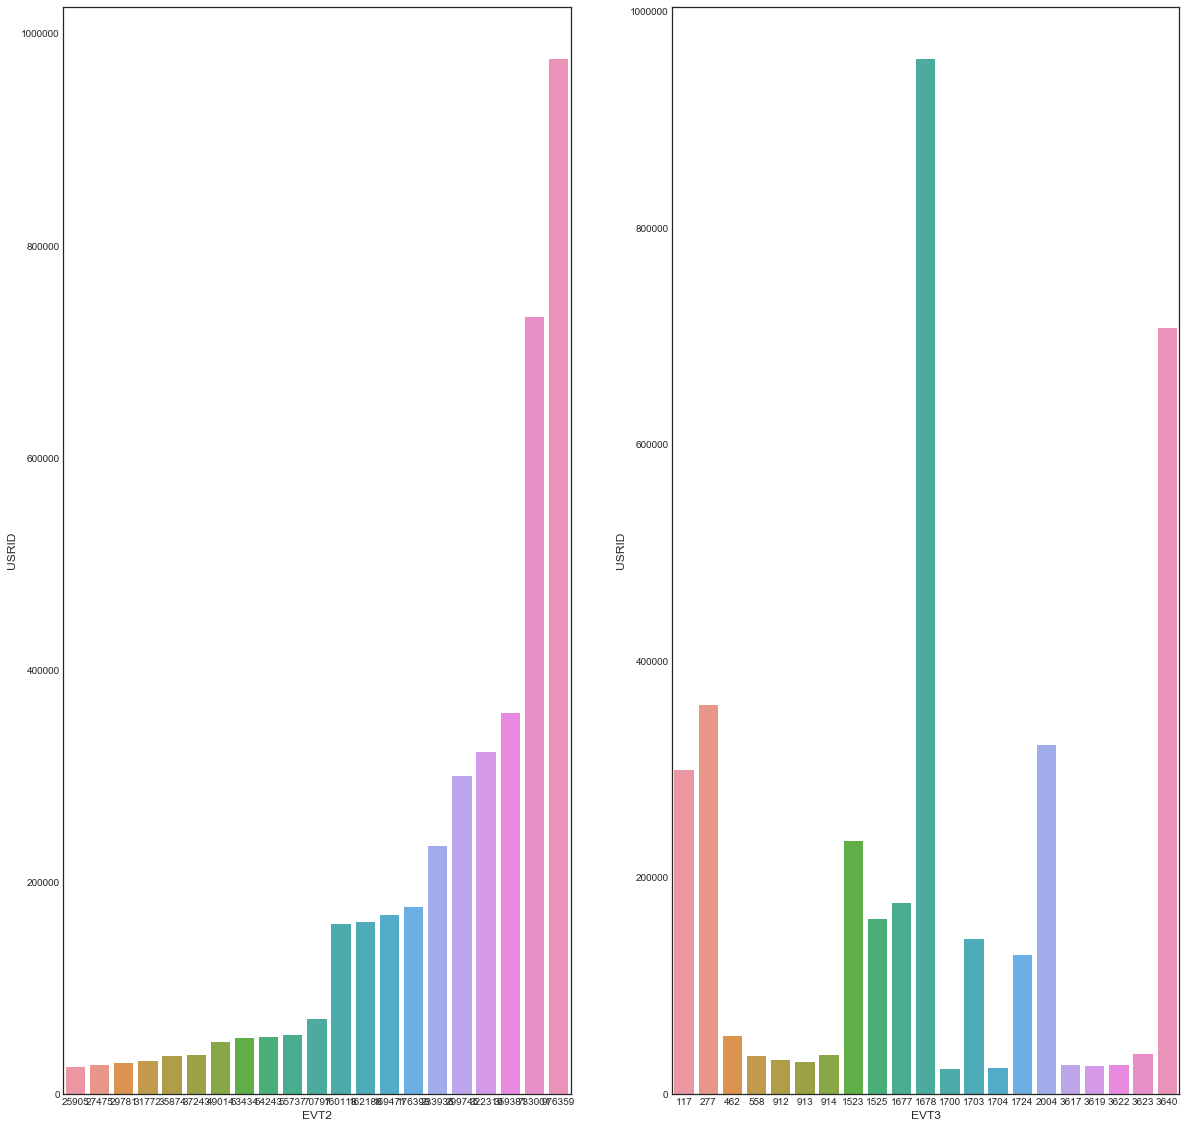

In [162]:
fig = plt.figure(figsize=(20,20))  
fig.add_subplot(121) 
sns.barplot(x='EVT2',y='USRID',data=EVT2)

fig.add_subplot(122) 
sns.barplot(x='EVT3',y='USRID',data=EVT3)

图中可以明显看出EVT2,EVT3数据量前十的特征值要明显多于之后十位，不过这里先保留21位，之后再进行优化。接下来将挑选出来的EVT2和EVT3作为各自新特征的前21个分类，其余分类都合并为'other'。

In [178]:
print(EVT2['USRID'].sort_values().head(1))
print('-'*10)
print(EVT3['USRID'].sort_values().head(1))

54    25905
Name: USRID, dtype: int64
----------
92    23333
Name: USRID, dtype: int64


可知21个特征中数量最少的个数分别为25905和23333.

In [179]:
EVT2_min=25905
EVT3_min=23333

In [180]:
EVT2_A= (log_data_c['EVT2'].value_counts() < EVT2_min)
EVT3_A= (log_data_c['EVT3'].value_counts() < EVT3_min)

In [183]:
log_data_c['EVT2'] = log_data_c['EVT2'].apply(lambda x: 0 if EVT2_A.loc[x] == True else x)
log_data_c['EVT3'] = log_data_c['EVT3'].apply(lambda x: 0 if EVT3_A.loc[x] == True else x)#定义0为其他特征

In [185]:
print(log_data_c['EVT2'].value_counts())
print('--'*10)
print(log_data_c['EVT3'].value_counts())

1041    976359
1836    733001
0       361041
231     359381
1234    322319
115     299745
922     233936
1040    176398
1042    169471
924     162188
1047    160118
392      70797
2148     55737
314      54243
1828     53434
1841     49014
1831     37243
578      35874
576      31772
577      29781
1830     27475
1046     25905
Name: EVT2, dtype: int64
--------------------
1678    956546
3640    708260
0       582484
277     359381
2004    322319
117     299745
1523    233936
1677    176398
1525    162188
1703    143332
1724    128229
462      54243
3623     37243
914      35874
558      35475
912      31772
913      29781
3622     27475
3617     27149
3619     26185
1704     23884
1700     23333
Name: EVT3, dtype: int64


In [170]:
?pd.DataFrame

## 数据合并

将train_agg数据和flg数据合并,并查看各特征与

In [168]:
train_data=pd.merge(train_agg,train_flg,on='USRID')
print(train_data.info())
print('-'*10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 80000 entries, 0 to 79999
Data columns (total 32 columns):
V1       80000 non-null float64
V2       80000 non-null float64
V3       80000 non-null float64
V4       80000 non-null float64
V5       80000 non-null float64
V6       80000 non-null float64
V7       80000 non-null float64
V8       80000 non-null float64
V9       80000 non-null float64
V10      80000 non-null float64
V11      80000 non-null float64
V12      80000 non-null float64
V13      80000 non-null float64
V14      80000 non-null float64
V15      80000 non-null float64
V16      80000 non-null float64
V17      80000 non-null float64
V18      80000 non-null float64
V19      80000 non-null float64
V20      80000 non-null float64
V21      80000 non-null float64
V22      80000 non-null float64
V23      80000 non-null float64
V24      80000 non-null float64
V25      80000 non-null float64
V26      80000 non-null float64
V27      80000 non-null float64
V28      80000 non-null flo